# Conducting and analysing A/B testing results

**Goal**   

Analise the results of the A/B tests and provide recommendations for the online-store revenue improvements.

**Plan**    
 
1. Review and data preprocessing
1. Checking the correctness of the performed tests
1. Creating additional dataframes with target and cumulative metrics
1. Exploratory data analyses
1. A/B test results analysis
1. Calculation of the statistical significance

## Data review

Importing necessary libraries

In [60]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
from IPython.display import display, Markdown
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 6]

Reading data from files

**Test participants**
   
      
- `user_id` — user identifier;
- `ab_test` — name of the test;
- `group` — user group.     

In [61]:
try: 
    final_ab_participants = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/AB%20tests/final_ab_participants.csv')
except: 
    print('File reading error. Check the URL')

display(final_ab_participants.sample(10))
display(final_ab_participants.info())

,user_id,group,ab_test
4155,38DA0BA08A977520,A,recommender_system_test
4679,EC9E9E250559033B,A,recommender_system_test
16314,642711159160F5FF,B,interface_eu_test
16304,FB82B9F6F3DA4C62,A,interface_eu_test
15320,6EE262E915126867,A,interface_eu_test
6971,DB4860DD68741AEE,A,interface_eu_test
4445,2A986C1D47CA7C87,A,recommender_system_test
12661,D7306BBCB3411F99,A,interface_eu_test
8771,8BD0081B1F369AA7,B,interface_eu_test
17829,BDD0564F61158B4E,A,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

In [62]:
final_ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

The file contains data not only about users who participated in the A/B test we are interested in. It will be necessary to filter out excessive data.

**New users**     
    
Registered between 7 and 21 December 2020.   
   
      
      
- `user_id` — user identifier;
- `first_date` — registration date;
- `region` — user's region;
- `device` — user registration device.

In [63]:
try:
    final_ab_new_users = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/AB%20tests/final_ab_new_users.csv')
except: 
    print('File reading error. Check the URL')
display(final_ab_new_users.sample(10))
display(final_ab_new_users.info())

,user_id,first_date,region,device
14480,DA7D081A70781049,2020-12-21,EU,PC
6075,AD1973EDF090F3A0,2020-12-14,EU,iPhone
23000,B9CDA57F47B4F367,2020-12-15,EU,iPhone
15199,09E2CB56DACE9C4F,2020-12-21,APAC,Mac
47732,D45FB4CC5F4D2DCE,2020-12-12,N.America,Android
55095,CF22F839C4F43160,2020-12-13,EU,Android
61381,FD32DAF37B9E1281,2020-12-20,CIS,iPhone
23657,C39A467C88FF3981,2020-12-15,APAC,Mac
58318,A03EAD12BAD403BC,2020-12-20,EU,Mac
21122,88F98E1DED83659E,2020-12-15,APAC,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

The same problem with this table: there are records about other tests.

**User activities**  
   
According to the requirements, user actions were recorded between 7 December 2020 and 4 January 2021.   
    
- `user_id` — user identifier;
- `event_dt` — date and time of the event;
- `event_name` — type of the event;
- `details` — additional data about the event. For example, for events `purchase` this field stores the purchase price in dollars.

In [64]:
try:
    final_ab_events = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/AB%20tests/final_ab_events.csv')
except: 
    print('File reading error. Check the URL')
    
display(final_ab_events.sample(10))
display(final_ab_events.info())

,user_id,event_dt,event_name,details
290126,3EE718562551ECDD,2020-12-13 14:58:18,login,NaN
227642,411119D22217B633,2020-12-24 15:14:30,product_page,NaN
391326,AA024D87B6F66D27,2020-12-22 09:17:22,login,NaN
178236,D397CBC636C2047C,2020-12-17 14:05:43,product_page,NaN
113155,738C5F219CA0CCC4,2020-12-23 11:52:46,product_cart,NaN
295355,602C340464965823,2020-12-14 01:48:08,login,NaN
266880,1A30D48A58C39C08,2020-12-10 01:47:00,login,NaN
115335,010D64A3EC7AF889,2020-12-24 21:27:53,product_cart,NaN
23175,87F7EB2CFEB6D11A,2020-12-16 23:53:31,purchase,4.99
276869,DCD99B2C594576A4,2020-12-11 07:36:47,login,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

**Marketing campaigns calendar 2020**    
    
- `name` — name of the campaign;
- `regions` — region where this campaign will be held;
- `start_dt` — date when campaign starts;
- `finish_dt` — date when campaign ends.    

In [65]:
try:
    ab_project_marketing_events = pd.read_csv('https://raw.githubusercontent.com/Rikka-irk/Data-Analysis/main/AB%20tests/ab_project_marketing_events.csv')
except: 
    print('File reading error. Check the URL')

display(ab_project_marketing_events.sort_values(by='start_dt'))
display(ab_project_marketing_events.info())

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

## Data preprocessing

### Data extraction

#### Test participants

Checking missing values

In [66]:
final_ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

From the table `final_ab_participants` electing only users participated in the test of our interest

In [67]:
test_participants = final_ab_participants\
      .loc[final_ab_participants\
      .ab_test == 'recommender_system_test']

display(test_participants.sample(5))

# collect the other test participants into a separate table
another_test_users = final_ab_participants.query("ab_test == 'interface_eu_test'")

,user_id,group,ab_test
4280,BA9906DF9975512E,B,recommender_system_test
3688,32BFB39666579FC1,B,recommender_system_test
336,A944D2BCDFD50619,A,recommender_system_test
2781,9F7BA4BA8A1C2563,A,recommender_system_test
1100,2EA84A8B0EE6739C,A,recommender_system_test


In [68]:
display(Markdown('**Number of unique users:**'), 
        test_participants['user_id'].nunique()     
       )

display(Markdown('**Number of test groups:**'), test_participants['group'].nunique()
     )

display(Markdown('**Test groups:**') ,
      test_participants['group'].unique().tolist()
     )
display(Markdown('**Number of users in test groups:**'))
display( test_participants[['user_id','group']].groupby('group').nunique())



**Number of unique users:**

6701

**Number of test groups:**

2

**Test groups:**

['A', 'B']

**Number of users in test groups:**

,user_id
group,
A,3824
B,2877


#### Registered users

Checking the missing values

In [69]:
final_ab_new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

Selecting from the `final_ab_new_users` only the A/B test participants from EU region

In [70]:
new_users = final_ab_new_users.query("user_id in @test_participants.user_id and region == 'EU'").copy()

#set the date as type "date" for further comparison operations
new_users['first_date'] = new_users['first_date'].astype('datetime64[ns]')

display(new_users.sample(5))

,user_id,first_date,region,device
13706,4AC7CA13200F4A8C,2020-12-21,EU,iPhone
3440,88FB1EDF3E249223,2020-12-07,EU,Android
33514,F5717EDCB0830A05,2020-12-10,EU,PC
23420,9C8CC142A4B89819,2020-12-15,EU,PC
4771,87C41A6F03A02CEA,2020-12-07,EU,iPhone


Let's write the time frame of the test in the variables.

In [71]:
ab_test_start = new_users['first_date'].min()
display(Markdown('**Start of the test and users registration:**'), ab_test_start)


new_users_register_fin = new_users['first_date'].max()
display(Markdown('**End of the user registrations:**'), new_users_register_fin)
        
ab_test_fin = pd.to_datetime('2021-01-04').date()
display(Markdown('**Planned end of the testing**'),ab_test_fin)

display(Markdown('**Number of unique registered users:**'),
      new_users['user_id'].nunique()
     )

display(Markdown('**Types of devices:**'),        
      new_users['device'].unique()
     )


**Start of the test and users registration:**

Timestamp('2020-12-07 00:00:00')

**End of the user registrations:**

Timestamp('2020-12-21 00:00:00')

**Planned end of the testing**

datetime.date(2021, 1, 4)

**Number of unique registered users:**

6351

**Types of devices:**

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

The number of registered users is lower than the number of the test participants.
It is possible that `final_ab_participants` table also contains users who registered after the user allocation has been stopped or users from other regions.  

Let's check this hypothesis:

In [72]:
#selecting users not appered in the `new_users` table
missed_users = test_participants.query('user_id not in @new_users.user_id')#['user_id']
display(missed_users)
#display(new_users.query('user_id not in @missed_users'))
#display(new_users.query('user_id not in @missed_users')['first_date'].max())

,user_id,group,ab_test
6351,800AF45A68291849,A,recommender_system_test
6352,8CB01194A7A8B2C6,B,recommender_system_test
6353,E93E75B64A774E02,B,recommender_system_test
6354,ECE67C0C773DCA8F,B,recommender_system_test
6355,01E9662F25EE4560,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


In [73]:
final_ab_new_users.query('user_id in @missed_users.user_id')['region'].value_counts().to_frame()

,region
N.America,223
APAC,72
CIS,55


Indeed, these users are from other regions.

#### Test participants' activity

Checking missing values

In [74]:
final_ab_events.isna().sum().to_frame()

,0
user_id,0
event_dt,0
event_name,0
details,377577


According to the requirements not all the records contain `details`

Select all the actions of the A/B test participant during the period of testing from the `final_ab_events` table.

In [75]:
#set the date to the data type "date", for further comparison operations
final_ab_events['event_dt'] = final_ab_events['event_dt'].astype('datetime64[ns]')

events = final_ab_events.query("(@ab_test_start <= event_dt <= @ab_test_fin) \
                and user_id in @test_participants.user_id").copy()

#Also collect another test participants' activities into a separate table
another_test_events = final_ab_events.query("(@ab_test_start <= event_dt <= @ab_test_fin) \
                and user_id in @another_test_users.user_id").copy()

In [76]:
display(Markdown('**Users:**'),
   events['user_id'].nunique()
      )

display(Markdown('**Activities during the A?B testing period:**'),
       events.shape[0]
      )

display(Markdown('**Activity types:**'),
   events['event_name'].unique()
      )

**Users:**

3675

**Activities during the A?B testing period:**

24698

**Activity types:**

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

There were even fewer users here. Not everyone who registered went to the site and made purchases.

Setting `date` at data type 

In [77]:
events['event_date'] = events['event_dt'].dt.date
events

,user_id,event_dt,event_name,details,event_date
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07
...,...,...,...,...,...
440239,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,2020-12-29
440258,96BDD55846D1F7F6,2020-12-29 16:53:42,login,NaN,2020-12-29
440267,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN,2020-12-29
440281,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN,2020-12-30


#### Conclusion

* Number of new users who took part in the test - 6701, of which:
    * In the control group - 3824
    * In the test group - 2877
    * Only 3675 users visited the site and performed any actions after the registration.
* The provided files also contain data about other tests performed.

### Checking data for anomalies

Distribution of order total price 

In [78]:
np.round(events[['details']].describe(percentiles=[0.97,0.98,0.99]))

,details
count,3331.0
mean,23.0
std,71.0
min,5.0
50%,5.0
97%,100.0
98%,100.0
99%,500.0
max,500.0


There are rare large orders in the data. Since in this study we are interested in conversion, not revenue, there is no need to remove them.

In [79]:
test_participants.sample(5)

,user_id,group,ab_test
6286,2E268F6ECDA395D6,A,recommender_system_test
154,E594B711ADD81DD8,A,recommender_system_test
4543,6EC64889E1189870,A,recommender_system_test
1368,5ECF8AD51FC8062E,A,recommender_system_test
5680,693C9126C80A3279,B,recommender_system_test


In [80]:
new_users.sample(5)

,user_id,first_date,region,device
1937,FA98254969FF4762,2020-12-07,EU,PC
48565,956779F8DB1A6218,2020-12-12,EU,PC
43118,AD16069CCDF9927B,2020-12-18,EU,Android
6809,D7E4F4E7A99546F1,2020-12-14,EU,iPhone
58137,A7CA7B2555BA40BB,2020-12-20,EU,PC


In [81]:
events.sample(5)

,user_id,event_dt,event_name,details,event_date
131296,4F095D257CB159C6,2020-12-08 02:03:37,product_page,NaN,2020-12-08
41995,055A4CD17A483B8E,2020-12-21 06:07:47,purchase,4.99,2020-12-21
181948,3AB66F0BF152DBEC,2020-12-18 18:05:16,product_page,NaN,2020-12-18
63902,EBBE8317E9D7B490,2020-12-07 03:46:01,product_cart,NaN,2020-12-07
236765,BB3873E1AC6E7BC3,2020-12-25 00:33:46,product_page,NaN,2020-12-25


The rest of the data does not require checks for anomalies.

### Duplicates processing

Check that each user is a participant of only one test group.

In [82]:
test_participants.groupby('user_id')['group'].nunique().to_frame().query('group > 1 ').count()

group    0
dtype: int64

In [83]:
new_users['user_id'].duplicated().sum()

0

Check the events' duplicates

In [84]:
events.duplicated().sum()

0

No duplicates found

### Checking the validity of the test performed

#### A/B testing period

Let's check that the events table contains activities for the correct period.

In [85]:
first_event_date = (final_ab_events.query("user_id in @test_participants.user_id")['event_dt'].min())
last_event_date = (final_ab_events.query("user_id in @test_participants.user_id")['event_dt'].max())

print('The first event:',first_event_date)
print('The last event:',last_event_date)

The first event: 2020-12-07 00:05:57
The last event: 2020-12-30 12:42:57


Event dates end before the scheduled end of the experiment. It can affect the analysis results. According to the requirements, we analyse user behaviour within 14 days period after the registration. So users registered after 15 December will have shorten event horizon. 

#### Intersection with the other tests participants

In [86]:
another_test_events = events.query("user_id in @another_test_users.user_id")
print('The second A/B test was from',
      another_test_events.event_dt.min(),
      'till',another_test_events.event_dt.max())


The second A/B test was from 2020-12-07 00:05:57 till 2020-12-30 12:42:57


Let's also check whether the selected users participated in other tests.

In [87]:
test_participants.set_index('user_id', drop=True, inplace=True)
new_users.set_index('user_id', drop=True, inplace=True)

In [88]:
user_data = new_users.join(test_participants,  how='inner')
display(user_data )

,first_date,region,device,group,ab_test
user_id,,,,,
D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
...,...,...,...,...,...
A09DFE27D4CFF8E8,2020-12-20,EU,Android,B,recommender_system_test
0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test


In [89]:
display(Markdown('**Users participated in other tests:**'), 
      final_ab_participants.query("user_id in @user_data.index ")
      .groupby('user_id')['ab_test'].nunique().to_frame()
      .query('ab_test > 1 ').count()[0]
     )

**Users participated in other tests:**

1602

Let's place the id of users participating in several tests at the same time in a separate table.

In [90]:
users_in_two_tests = (final_ab_participants.query("user_id in @user_data.index ")
      .groupby('user_id')['ab_test'].nunique().to_frame()
      .query('ab_test > 1 ').sort_values('ab_test').index)

The number of users in both tests by groups.

In [91]:
final_ab_participants.groupby(['ab_test','group']).count()

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

In [92]:
display(user_data.groupby('group')['first_date'].count().to_frame())

,first_date
group,
A,3634
B,2717


Select the participants of the second A/B test.

In [93]:
other_test_users = final_ab_participants.query("ab_test == 'interface_eu_test'").set_index('user_id')
other_test_users.columns = ['group2','test2']

display(other_test_users)

,group2,test2
user_id,,
D4E530F6595A05A3,A,interface_eu_test
773ECB64E45DEBAB,A,interface_eu_test
6BCB0F33D3BAB8C2,A,interface_eu_test
AABA4219186465C9,A,interface_eu_test
2BA8FA8754D1FE50,B,interface_eu_test
...,...,...
1D302F8688B91781,B,interface_eu_test
3DE51B726983B657,A,interface_eu_test
F501F79D332BE86C,A,interface_eu_test


Join this data to the users we are interested in.

In [94]:
user_data = user_data.join(other_test_users, how = 'left')
user_data = user_data.fillna('no_data')

display(user_data)

,first_date,region,device,group,ab_test,group2,test2
user_id,,,,,,,
D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,no_data,no_data
E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,B,interface_eu_test
DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,A,interface_eu_test
831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,no_data,no_data
4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test,no_data,no_data
...,...,...,...,...,...,...,...
A09DFE27D4CFF8E8,2020-12-20,EU,Android,B,recommender_system_test,B,interface_eu_test
0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test,no_data,no_data
574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test,no_data,no_data


Let's make a pivot table showing the number of users who participated in the two tests.

In [95]:
tests_dist_pivot =  user_data.reset_index().pivot_table(columns='group2', values='user_id', index='group', aggfunc='nunique')
tests_dist_pivot

group2,A,B,no_data
group,,,
A,482,439,2713
B,337,344,2036


Turn it into ratios

In [96]:
tests_dist_pivot.div(tests_dist_pivot.sum(axis=1), axis=0)

group2,A,B,no_data
group,,,
A,0.132636,0.120804,0.746560
B,0.124034,0.126610,0.749356


74% of users from the test and control groups of the Recommendations test did not participate in other tests.       
    
26% of users also participated in another test. But the distribution of participants in the control and test groups of both tests is uniform, so the impact of the second test on both groups is equal and should not create a problem.

#### Marketing campaigns

In [97]:
#set the date to the data type "date", for further comparison operations
ab_project_marketing_events['start_dt'] = ab_project_marketing_events['start_dt'].astype('datetime64[ns]').dt.date
ab_project_marketing_events['finish_dt'] = ab_project_marketing_events['finish_dt'].astype('datetime64[ns]').dt.date

campaigns = ab_project_marketing_events.loc[ab_project_marketing_events.regions.str.contains('EU')].copy()

print('')
print('Marketing campaigns during the new users allocation period:',
       campaigns
          .query(" (@ab_test_start< start_dt < @new_users_register_fin) \
                 and  (@ab_test_start< finish_dt < @new_users_register_fin) ")
          .shape[0]
     )

print('')
print('Marketing campaigns during the A/B testing period:', 
      campaigns
       .query(" (@ab_test_start< start_dt < @ab_test_fin)\
       and  (@ab_test_start< finish_dt < @ab_test_fin) ")
      .shape[0]
     )
display(campaigns
       .query(" (@ab_test_start< start_dt < @ab_test_fin)\
       and  (@ab_test_start< finish_dt < @ab_test_fin) ")
        )


Marketing campaigns during the new users allocation period: 0

Marketing campaigns during the A/B testing period: 1


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


There were no marketing campaigns during the allocation of new users.   
But after that, during testing, there was one New Year promotional campaign from December 25 to January 3.   
We should pay attention to user activity during this period.

#### Conclusion

* Event records end before the scheduled end of the test - 30.12 instead of 4.01. Therefore not all users have a 14-day lifetime, as specified in the test requirements.
    * To solve this problem, we will count metrics for 14 days for those who's lifetime is 14 days, and 7 for the rest. 
    * This approach will help to evaluate the results of an A/B test with a large number of users meeting the requirements.
* Also, the end of the testing period coincides with the end of the New Year advertising campaign, which could also affect user activity.
    * Pay attention to the users' activity during this period for a presence of outliers and anomalies.
* More over, some of the registered test participants also took part in a parallel A/B testing of another feature.
    * Users are evenly distributed between tests and there is no skewness towards one of the control or test groups.

### Creating additional dataframes

####  User target metrics at 7- and 14-day time intervals

In [98]:
events = events.set_index('user_id').join(user_data, how='inner').reset_index()
events = events.rename(columns={'details':'revenue'})

display(events.sample(5))

,user_id,event_dt,event_name,revenue,event_date,first_date,region,device,group,ab_test,group2,test2
7921,56EE3A6402B3BAC0,2020-12-16 20:58:38,product_cart,NaN,2020-12-16,2020-12-16,EU,PC,A,recommender_system_test,no_data,no_data
16986,B893A9176CA2DDCC,2020-12-20 01:12:16,login,NaN,2020-12-20,2020-12-20,EU,PC,A,recommender_system_test,no_data,no_data
97,00EFA157F7B6E1C4,2020-12-10 14:43:26,login,NaN,2020-12-10,2020-12-09,EU,Android,A,recommender_system_test,A,interface_eu_test
11894,84EB34779A251529,2020-12-19 15:15:18,login,NaN,2020-12-19,2020-12-19,EU,iPhone,B,recommender_system_test,no_data,no_data
3397,2556F5BDA0E0723B,2020-12-10 13:30:53,product_cart,NaN,2020-12-10,2020-12-10,EU,Android,A,recommender_system_test,no_data,no_data


Create a users dataframe with columns +14 and +7 days from the registration date for further evaluation of the users' event horizon and eligibility.

In [99]:
#Creating columns:

#    with a date "+14 days from the registration date"
events['day_14'] = events['first_date'] + pd.Timedelta(days=14)

#    with a date "+7 days from the registration date"
events['day_7'] = events['first_date'] + pd.Timedelta(days=7)
display(events.sample(5))

,user_id,event_dt,event_name,revenue,event_date,first_date,region,device,group,ab_test,group2,test2,day_14,day_7
21812,EE9E527A761299B2,2020-12-23 13:41:04,login,NaN,2020-12-23,2020-12-21,EU,PC,B,recommender_system_test,A,interface_eu_test,2021-01-04,2020-12-28
4315,2F28A3B279E5494A,2020-12-17 16:00:16,product_cart,NaN,2020-12-17,2020-12-14,EU,Android,A,recommender_system_test,B,interface_eu_test,2020-12-28,2020-12-21
18421,C716AF018B3D96F5,2020-12-27 20:27:14,login,NaN,2020-12-27,2020-12-17,EU,iPhone,A,recommender_system_test,no_data,no_data,2020-12-31,2020-12-24
1717,12E86A81CC9AA775,2020-12-26 05:12:50,login,NaN,2020-12-26,2020-12-21,EU,PC,A,recommender_system_test,no_data,no_data,2021-01-04,2020-12-28
7245,4F27E0ECC98D9F89,2020-12-20 22:45:21,product_page,NaN,2020-12-20,2020-12-20,EU,Android,B,recommender_system_test,no_data,no_data,2021-01-03,2020-12-27


In [100]:
#adding a flag for each user
#whether there was an activity of each type during the 14 days period

users_events_d14 = (events.query("event_date <= day_14")
                    .groupby(['user_id','event_name'])['event_date']
                    .min().unstack())

users_events_d14 = users_events_d14.where(users_events_d14.isnull(), 1).fillna(0)
display(users_events_d14.sample(5))

event_name,login,product_cart,product_page,purchase
user_id,,,,
4A61A28F35795FD1,1,0,0,0
4438A8DB1591E2FD,1,1,0,0
5673140CA30564D5,1,1,0,0
6E3DF9C69A6B607E,1,1,1,0
66E0CBF90827B836,1,0,1,0


In [101]:
#adding a flag for each user
#whether there was an activity of each type during the 7 days period

users_events_d7 = (events.query("event_date <= day_7")
                    .groupby(['user_id','event_name'])['event_date']
                    .min().unstack())

users_events_d7 = users_events_d7.where(users_events_d7.isnull(), 1).fillna(0)
display(users_events_d7.sample(5))

event_name,login,product_cart,product_page,purchase
user_id,,,,
6070727198404A40,1,0,0,0
6610064A4B2303D1,1,0,1,0
EF3118771FB74F92,1,0,0,0
E3780F6861A69868,1,0,0,0
5D4B70B71BD714AD,1,0,1,1


In [102]:
#creating dataframes for users:

    #who's lifetime is no less than 14 days
user_data_d14 = user_data.loc[(last_event_date - user_data['first_date']).dt.days >= 14]

    #who's lifetime is no less than 7 days
user_data_d7 = user_data.loc[(last_event_date - user_data['first_date']).dt.days >= 7]
display(user_data_d14.sample(5))   
display(user_data_d7.sample(5))

,first_date,region,device,group,ab_test,group2,test2
user_id,,,,,,,
826966D0867A0E28,2020-12-08,EU,Android,B,recommender_system_test,A,interface_eu_test
50AA33C3098BDDE2,2020-12-10,EU,Android,A,recommender_system_test,B,interface_eu_test
47EEC31E3D0C6E8B,2020-12-10,EU,Android,B,recommender_system_test,no_data,no_data
A241F8D0DEF95F32,2020-12-11,EU,Mac,A,recommender_system_test,B,interface_eu_test
0FE0324B5431F1FF,2020-12-11,EU,PC,A,recommender_system_test,no_data,no_data


,first_date,region,device,group,ab_test,group2,test2
user_id,,,,,,,
C6E67DC34B047AA2,2020-12-15,EU,Mac,A,recommender_system_test,no_data,no_data
D275276F3490096F,2020-12-14,EU,Android,A,recommender_system_test,no_data,no_data
6E8C4C4691828595,2020-12-14,EU,Android,A,recommender_system_test,no_data,no_data
963F921521088A5C,2020-12-18,EU,Android,B,recommender_system_test,no_data,no_data
8A401E7C2E0DAE58,2020-12-09,EU,iPhone,B,recommender_system_test,no_data,no_data


In [103]:
#Adding the event flags into thusers tables
#for users without any activity the flag is set to 0
user_data_d14 = user_data_d14.join(users_events_d14, how='left').fillna(0)
user_data_d7 = user_data_d7.join(users_events_d7, how='left').fillna(0)
display(user_data_d14.sample(5))
display(user_data_d7.sample(5))

,first_date,region,device,group,ab_test,group2,test2,login,product_cart,product_page,purchase
user_id,,,,,,,,,,,
59BA4B15D73A2A6C,2020-12-14,EU,Android,A,recommender_system_test,no_data,no_data,1.0,0.0,1.0,0.0
9999E0476CE6B08B,2020-12-14,EU,iPhone,A,recommender_system_test,no_data,no_data,1.0,1.0,0.0,1.0
3807E97EF5DD2E4E,2020-12-10,EU,Android,B,recommender_system_test,no_data,no_data,0.0,0.0,0.0,0.0
0B0C9CDFCA3EFF8A,2020-12-13,EU,PC,B,recommender_system_test,no_data,no_data,1.0,1.0,0.0,0.0
7CEFBD3C6ABEF91A,2020-12-09,EU,iPhone,A,recommender_system_test,A,interface_eu_test,1.0,0.0,0.0,0.0


,first_date,region,device,group,ab_test,group2,test2,login,product_cart,product_page,purchase
user_id,,,,,,,,,,,
D6434FEC52FD20BE,2020-12-08,EU,Mac,B,recommender_system_test,no_data,no_data,0.0,0.0,0.0,0.0
A138781ABFFF27AC,2020-12-15,EU,Mac,B,recommender_system_test,no_data,no_data,0.0,0.0,0.0,0.0
E6C4C8D05ED980DC,2020-12-17,EU,PC,B,recommender_system_test,no_data,no_data,0.0,0.0,0.0,0.0
60070049AB41EA28,2020-12-20,EU,Android,B,recommender_system_test,no_data,no_data,0.0,0.0,0.0,0.0
051112E3FE1F2E55,2020-12-18,EU,PC,B,recommender_system_test,no_data,no_data,1.0,1.0,0.0,0.0


#### Cumulative metrics by days 

##### Logins

Creating a pivot table for the number of logged in users for each day.

In [104]:
logins  = events.query("event_name =='login'")
logins_pivot = logins.pivot_table(columns='group', values='event_name', index='event_date',aggfunc='count')
display(logins_pivot)

group,A,B
event_date,,
2020-12-07,148.0,155.0
2020-12-08,146.0,113.0
2020-12-09,171.0,161.0
2020-12-10,156.0,124.0
2020-12-11,176.0,84.0
2020-12-12,168.0,102.0
2020-12-13,154.0,81.0
2020-12-14,461.0,120.0
2020-12-15,452.0,109.0


##### Products views

Making a pivot table for product views by dates.

In [105]:
product_views = events.query("event_name =='product_page'")
product_views_pivot = product_views.pivot_table(columns='group', 
                                                values='event_name', 
                                                index='event_date',
                                                aggfunc='count').fillna(0)
display(product_views_pivot)

group,A,B
event_date,,
2020-12-07,92.0,101.0
2020-12-08,98.0,61.0
2020-12-09,103.0,99.0
2020-12-10,88.0,67.0
2020-12-11,96.0,45.0
2020-12-12,93.0,51.0
2020-12-13,88.0,41.0
2020-12-14,285.0,59.0
2020-12-15,286.0,52.0


##### Cart views

Creating a pivot table for product cart views by dates.

In [106]:
cart_views = events.query("event_name =='product_cart'")
cart_views_pivot = cart_views.pivot_table(columns='group', 
                                          values='event_name', 
                                          index='event_date',
                                          aggfunc='count')
display(cart_views_pivot)

group,A,B
event_date,,
2020-12-07,35.0,41.0
2020-12-08,36.0,31.0
2020-12-09,50.0,39.0
2020-12-10,45.0,32.0
2020-12-11,44.0,16.0
2020-12-12,47.0,21.0
2020-12-13,34.0,16.0
2020-12-14,136.0,37.0
2020-12-15,155.0,29.0


##### Purchases

Creating a pivot table for purchase number by dates.

In [107]:
purchases = events.query("event_name =='purchase'")
purchases_pivot = purchases.pivot_table(columns='group', 
                                        values='event_name', 
                                        index='event_date',
                                        aggfunc='count')
display(purchases_pivot)

group,A,B
event_date,,
2020-12-07,43,59
2020-12-08,33,33
2020-12-09,47,39
2020-12-10,42,26
2020-12-11,40,16
2020-12-12,38,25
2020-12-13,32,26
2020-12-14,133,32
2020-12-15,137,32


##### Revenue

A pivot table for daily revenue.

In [108]:
revenue_pivot = purchases.pivot_table(columns='group', 
                                      values='revenue', 
                                      index='event_date',
                                      aggfunc='sum')
display(revenue_pivot)

group,A,B
event_date,,
2020-12-07,1104.57,704.41
2020-12-08,754.67,484.67
2020-12-09,759.53,414.61
2020-12-10,809.58,639.74
2020-12-11,1089.60,94.84
2020-12-12,879.62,324.75
2020-12-13,289.68,1424.74
2020-12-14,3273.67,769.68
2020-12-15,3288.63,1459.68


##### Average transaction value

Create a pivot table for an average transaction value for each day.

In [109]:
mean_spend_pivot = purchases.pivot_table(columns='group', 
                                         values='revenue', 
                                         index='event_date',
                                         aggfunc='mean')
display(mean_spend_pivot)

group,A,B
event_date,,
2020-12-07,25.687674,11.939153
2020-12-08,22.868788,14.686970
2020-12-09,16.160213,10.631026
2020-12-10,19.275714,24.605385
2020-12-11,27.240000,5.927500
2020-12-12,23.147895,12.990000
2020-12-13,9.052500,54.797692
2020-12-14,24.614060,24.052500
2020-12-15,24.004599,45.615000


##### Registration

A pivot table containing the amount of new users registrations by date.

In [110]:
users_join_daily = user_data.pivot_table(columns='group',
                                         values='ab_test',
                                         index='first_date',
                                         aggfunc='count')
users_join_daily = revenue_pivot.drop(['A', 'B'], axis=1).join(users_join_daily).fillna(0)
display(users_join_daily)

group,A,B
event_date,,
2020-12-07,349.0,259.0
2020-12-08,186.0,149.0
2020-12-09,143.0,105.0
2020-12-10,189.0,181.0
2020-12-11,157.0,106.0
2020-12-12,268.0,198.0
2020-12-13,323.0,228.0
2020-12-14,366.0,262.0
2020-12-15,202.0,141.0


After the 21st of December user allocation was stopped.

## Exploratory data analysis

### Events per user by group

In [111]:
events.groupby(['user_id','group'])['event_date'].count().reset_index()\
      .groupby('group')['event_date'].mean().to_frame()

,event_date
group,
A,7.031106
B,5.827822


The control group has 7 events per user on average, while the test group has only 5.8.

### Event distribution in groups by date

In [112]:
events_pivot = events.pivot_table(columns='group', values='event_name', index='event_date',aggfunc='count').fillna(0)
display(events_pivot)

group,A,B
event_date,,
2020-12-07,318.0,356.0
2020-12-08,313.0,238.0
2020-12-09,371.0,338.0
2020-12-10,331.0,249.0
2020-12-11,356.0,161.0
2020-12-12,346.0,199.0
2020-12-13,308.0,164.0
2020-12-14,1015.0,248.0
2020-12-15,1030.0,222.0


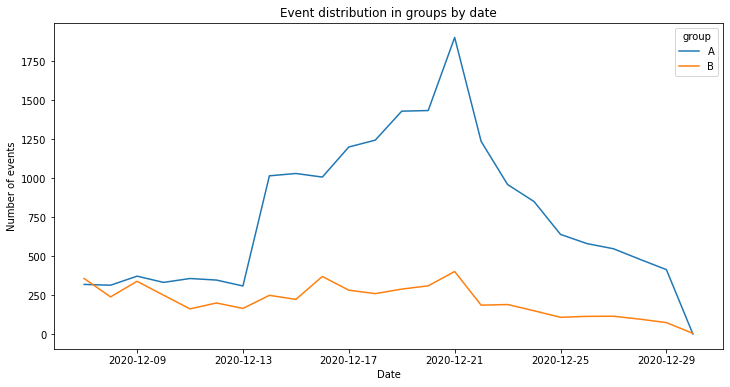

In [113]:

events_pivot.plot()
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.title('Event distribution in groups by date')
plt.show();

In [114]:
events_pivot.mean().to_frame()

,0
group,
A,762.875000
B,212.958333


* The test group users perform 213 actions per day on average, while the control group users perform 769 actions per day.
* The control group users activity increases during period from the 13th of December and reaches its peak on the 20th. 
* The test group users activity does not change significantly during the whole period of test.

### Change of conversion rates in the funnel by groups

In [115]:
funnel =  events.pivot_table(columns='group',
                   index='event_name',
                   values='user_id', 
                   aggfunc='nunique')                  

In [116]:
user_data.groupby('group')['first_date'].count().to_frame()

,first_date
group,
A,3634
B,2717


Calculating the user conversion funnel.

In [117]:
funnel.loc['registered'] = user_data.groupby('group')['first_date'].count()
funnel = funnel.loc[['registered','login','product_page','product_cart','purchase']]
funnel

group,A,B
event_name,,
registered,3634,2717
login,2604,877
product_page,1685,493
product_cart,782,244
purchase,833,249


The same data in percents.

In [118]:
funnel/funnel.loc['registered']

group,A,B
event_name,,
registered,1.000000,1.000000
login,0.716566,0.322782
product_page,0.463676,0.181450
product_cart,0.215190,0.089805
purchase,0.229224,0.091645


In [119]:
funnel/funnel.loc['login']

group,A,B
event_name,,
registered,1.395545,3.098062
login,1.000000,1.000000
product_page,0.647081,0.562144
product_cart,0.300307,0.278221
purchase,0.319892,0.283922


Let's also build a funnel for users who participated in only one of our tests, to check if there is any influence of the parallel test on the results.

In [120]:
funnel =  events.query("user_id not in @another_test_users.user_id")\
                  .pivot_table(columns='group',
                               index='event_name',
                               values='user_id', 
                               aggfunc='nunique')
                  

In [121]:
user_data.groupby('group')['first_date'].count().to_frame()

,first_date
group,
A,3634
B,2717


In [122]:
funnel.loc['registered'] = user_data.query("user_id not in @another_test_users.user_id").groupby('group')['first_date'].count()
funnel = funnel.loc[['registered','login','product_page','product_cart','purchase']]
funnel

group,A,B
event_name,,
registered,2713,2036
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


In [123]:
funnel/funnel.loc['registered']

group,A,B
event_name,,
registered,1.000000,1.000000
login,0.714707,0.321709
product_page,0.466273,0.180255
product_cart,0.217103,0.090373
purchase,0.225949,0.093811


In [124]:
funnel/funnel.loc['login']

group,A,B
event_name,,
registered,1.399175,3.108397
login,1.000000,1.000000
product_page,0.652398,0.560305
product_cart,0.303765,0.280916
purchase,0.316142,0.291603


### Conclusion

* A very significant drop in conversion in the test group between registration and login. There is clearly a problem with logins - perhaps users don't receive an email with registration confirmation and forget about our site, or the site with a new interface has a bug with login for new users. We need to inform the development team about it.
    * In connection with the problem described above, in the future we will analyse two types of funnels - those starting with registration and those starting with login.
* Conducting the second test at the same time did not affect user conversion.

## A/B test results analysis 

### Number of orders by group

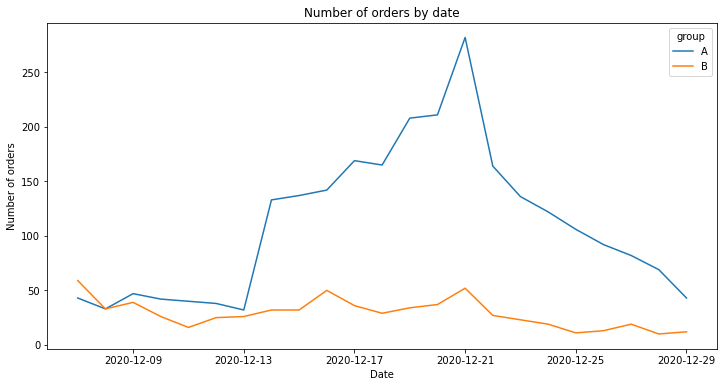

In [125]:
purchases_pivot.plot()
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Number of orders by date')
plt.show();

**Cumulative number of orders by group**

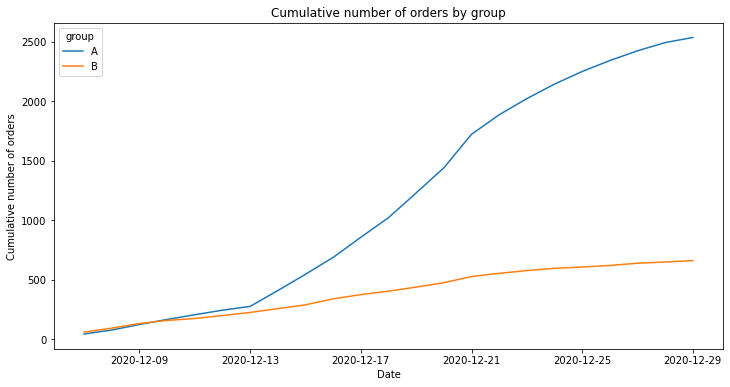

In [126]:
purchases_pivot.cumsum().plot()
plt.xlabel('Date')
plt.ylabel('Cumulative number of orders')
plt.title('Cumulative number of orders by group')
plt.show();

The chart shows that something happened on the 13th of December and users from the control group started buying many times more. However, since there were no promotions on that day, it is worth checking the activity of users who participated in the parallel test. Perhaps it will help to clarify the situation.

**Number of orders by group in the second test**

In [127]:
another_test_events = another_test_events.merge(another_test_users, on='user_id', how='inner')
another_test_events_pivot = another_test_events.pivot_table(columns='group', values='event_name', index='event_date',aggfunc='count').fillna(0)


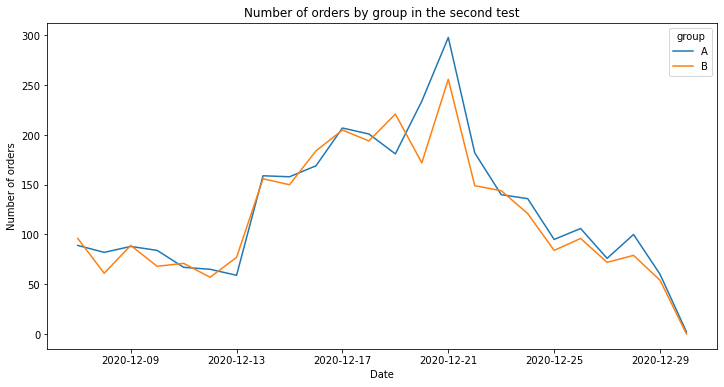

In [130]:
another_test_events_pivot.plot()
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Number of orders by group in the second test')
plt.show();

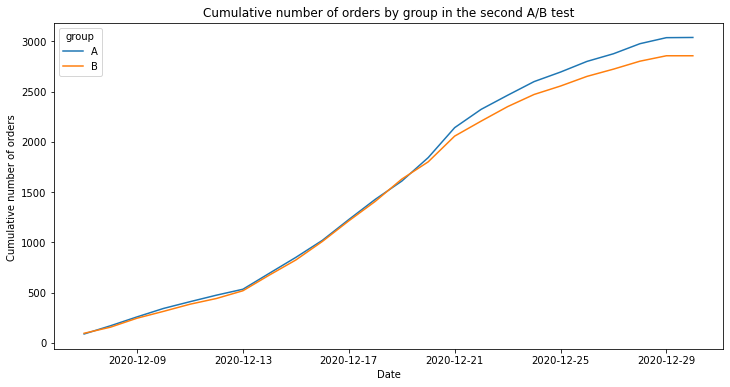

In [129]:
another_test_events_pivot.cumsum().plot()
plt.xlabel('Date')
plt.ylabel('Cumulative number of orders ')
plt.title('Cumulative number of orders by group in the second A/B test')
plt.show();

The behaviour of both groups of the parallel test coincides with the behaviour of the control group of the recommendation test. It means that the new recommendation system affected the users from the test group in a negative way.

#### Conclusion

* The chart shows a strong difference in the number of orders between the test and control groups. 
* The control group has a sharp increase in the number of purchases around 13-14 December, while the test group does not have such a jump and the number of purchases remains relatively stable throughout the test period.
* The sudden increase in user activity on 13-14 December is not an anomaly in the control group of the recommendation test, as it is also present in the second test in both groups.
* No influence of the advertising campaign conducted from 25.12 to 3.01 was observed.

###  Cumulative average transaction value by group

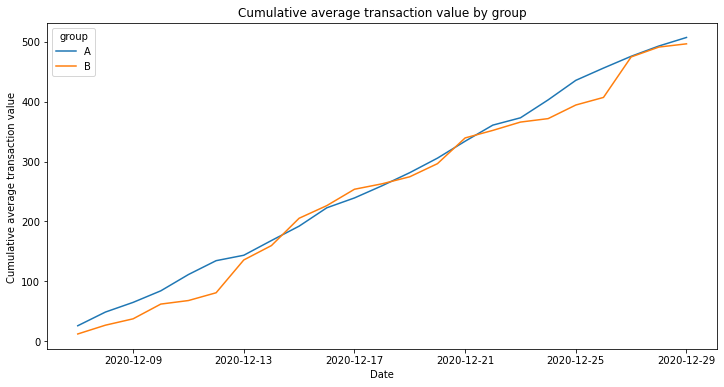

In [133]:
mean_spend_pivot.cumsum().plot()
plt.xlabel('Date')
plt.ylabel('Cumulative average transaction value ')
plt.title('Cumulative average transaction value by group')
plt.show();

#### Conclusion

* Unlike the number of purchases, there is no difference in the average transaction value between the test and control groups.

### Transaction values

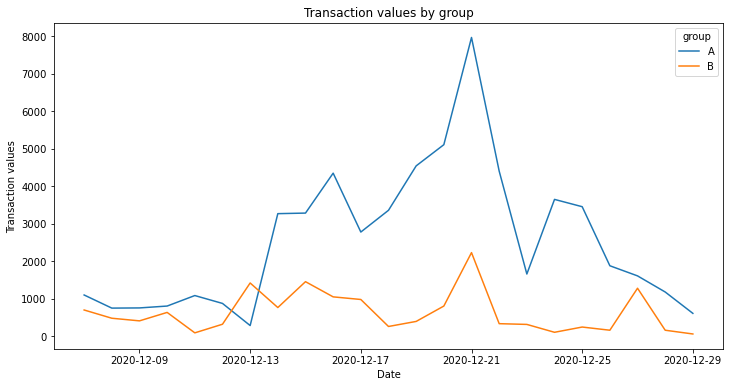

In [134]:
revenue_pivot.plot()
plt.xlabel('Date')
plt.ylabel('Transaction values')
plt.title('Transaction values by group')
plt.show();

#### Conclusion

* Along with the number of orders in the control group from 13-14 December, the total revenue is also increasing.
* There is a small peak around the 21st of December, possibly caused by the advertising campaign. However, this effect is insignificant within the entire test.

### Relative change in cumulative average transaction value

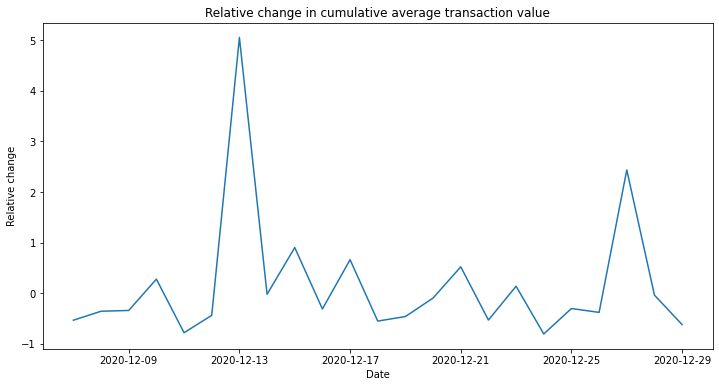

In [135]:
(mean_spend_pivot['B'] / mean_spend_pivot['A'] - 1).plot()
plt.xlabel('Date')
plt.ylabel('Relative change')
plt.title('Relative change in cumulative average transaction value')
plt.show();

#### Conclusion

* The average transaction value between the test and control groups is not significantly different.
* There is only one noticeable outlier around the 13th of December.
* There is a small outlier after 25 December, possibly caused by an advertising campaign.

###  Cumulative conversion by group

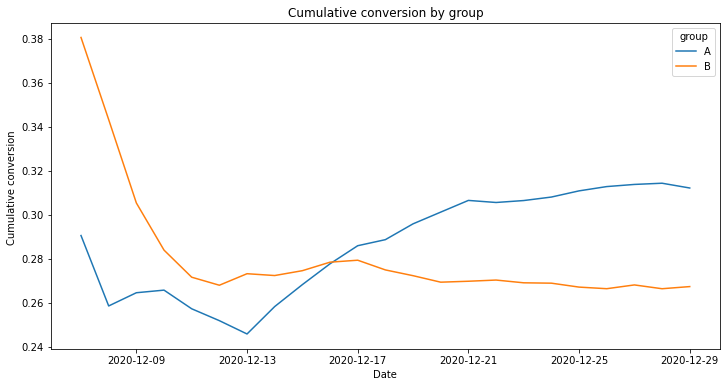

In [137]:
cum_conv = (purchases_pivot.cumsum() / logins_pivot.cumsum())
(purchases_pivot.cumsum() / logins_pivot.cumsum()).plot()
plt.xlabel('Date')
plt.ylabel('Cumulative conversion ')
plt.title('Cumulative conversion by group')
plt.show()

#### Conclusion

* There is a drastic drop in the cumulative conversion rate of the test group during the first week of the test. This is probably due to the above-mentioned problem of low level of users returning to the site after registration.
* After the 13th of December the cumulative conversion rate of the test group remains relatively constant.
* The control group also shows a relatively insignificant decrease in conversion at the beginning of the test period.
* After 13 December, the cumulative conversion rate of the control group is steadily increasing.
* The influence of the New Year advertising campaign on the conversion rate is not noticeable.

### Relative change in cumulative conversion of group B to group A

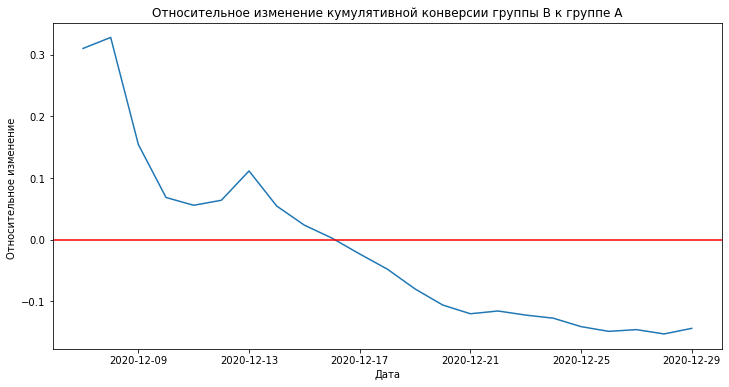

In [75]:
(cum_conv['B'] / cum_conv['A'] - 1).plot()
plt.axhline(0, c='red')
plt.xlabel('Date')
plt.ylabel('Relative change ')
plt.title('Relative change in cumulative conversion of group B to group A')
plt.show();

#### Conclusion

* The difference between groups changes from positive to negative over the time period.
* At the beginning of the test period, the cumulative conversion rate in the test group was higher than in the control group. 
* After about 16 December, the cumulative conversion of the control group exceeded the test group.

### Statistical significance

Create a function for z-test.

In [138]:
def z_test(data, metric, alpha = .05):

    conversionA = data.loc[data.group == 'A', metric].astype('int')
    conversionB = data.loc[data.group == 'B', metric].astype('int')

    successes = np.array([conversionA.sum(), conversionB.sum()])
    trials = np.array([conversionA.count(), conversionB.count()])

    # success ratio of the first group
    p1 = successes[0]/trials[0]

    # success ratio of the second group
    p2 = successes[1]/trials[1]

    # success ratio of the first group in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # success ratio difference
    difference = p1 - p2 

    # count statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # set standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)  


    # count statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if p_value < alpha:
        print('Reject the null hypothesis: there is a significant difference between the shares')
    else:
        print(
            'Failed to reject the null hypothesis, there is no reason to consider the fractions to be different'
        ) 

    print('relative change in B to A = {0:.3f}'.format(
        conversionB.mean() / 
        conversionA.mean() - 1))    

#### Conversion to viewing product cards

$H_0$: There is no difference in conversion to product browsing between test and control groups

$H_1$: Conversion to product browsing in control group is at least +10% higher than the test group with the new feature.

For users with a lifetime of 14 days 

Registration as the beginning of a funnel

In [143]:
z_test(user_data_d14, 'product_page')

p-value:  0.0
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.439


Login as the beginning of a funnel

In [144]:
z_test(user_data_d14.query("login == 1"), 'product_page')

p-value:  0.01736522155918485
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.091


For users with a lifetime of 7 days 

Registration as the beginning of a funnel

In [145]:
z_test(user_data_d7, 'product_page')

p-value:  0.0
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.609


Login as the beginning of a funnel

In [146]:
z_test(user_data_d7.query("login == 1"), 'product_page')

p-value:  7.31671814202528e-06
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.131


##### Conclusion

* User conversion between registration and product browsing is different between groups by 43% in favour of the control group for users with a lifetime of 14 days and 60% for 7 days.
* The probability of making a mistake when rejecting the null hypothesis is close to zero.
    * The control group showed better conversion results with the new recommendation feature than the test group.
* In case of counting the conversion from the stage of user login to the site, the difference between the conversions of the two groups is strongly reduced and amounts to 9% for users with 14 days of lifetime and 13% with 7 days in favour of the control group.
    * However, this difference is still large and does not give any reason to consider the groups the same.
* There was no expected improvement in conversions when the new feature was added to the site.

#### Conversion to basket view

$H_0$: There is no difference in conversion to basket view between test and control groups

$H_1$: Conversion to  basket view in control group is at least +10% higher than the test group with the new feature.

For users with a lifetime of 14 days 

Registration as the beginning of a funnel

In [147]:
z_test(user_data_d14, 'product_cart')

p-value:  8.22533152700089e-11
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.422


Login as the beginning of a funnel

In [148]:
z_test(user_data_d14.query("login == 1"), 'product_cart')

p-value:  0.39503207429426856
Failed to reject the null hypothesis, there is no reason to consider the fractions to be different
relative change in B to A = -0.064


For users with a lifetime of 7 days 

Registration as the beginning of a funnel

In [149]:
z_test(user_data_d7, 'product_cart')

p-value:  0.0
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.583


Login as the beginning of a funnel

In [150]:
z_test(user_data_d7.query("login == 1"), 'product_cart')

p-value:  0.22866282948887662
Failed to reject the null hypothesis, there is no reason to consider the fractions to be different
relative change in B to A = -0.071


##### Conclusion

* Conversion from registration to cart browsing of the control group is higher by 42% for users with a lifetime of 14 days and 58% for 7 days. 
    * In this case, when the null hypothesis is rejected, the chance of making a mistake tends to zero.
    * Hence the control group performed better than the group with the new recommendation engine.
* When taking the login stage as the starting point, the difference in conversion is greatly reduced. 
    * The conversion of the control group is only 6.4% higher than the test group for users with a lifetime of 14 days and 7.1% for 7 days.
    * In this case, the difference between the groups is insignificant and there is no reason to reject the null hypothesis.
    * This suggests that the new recommendation engine had a negative effect on users at the stage between registration and login. At further stages its impact is not significant.

#### Conversion to purchases 

$H_0$: There is no difference in conversion to purchases between test and control groups

$H_1$: Conversion to purchases in control group is at least +10% higher than the test group with the new feature.

For users with a lifetime of 14 days

Registration as the beginning of the funnel

In [151]:
z_test(user_data_d14, 'purchase')

p-value:  8.83967343767722e-10
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.402


Login as the beginning of a funnel

In [152]:
z_test(user_data_d14.query("login == 1"), 'purchase')

p-value:  0.6222750186056665
Failed to reject the null hypothesis, there is no reason to consider the fractions to be different
relative change in B to A = -0.037


For users with a lifetime of 7 days

Registration as the beginning of a funnel

In [153]:
z_test(user_data_d7, 'purchase')

p-value:  0.0
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.600


Login as the beginning of a funnel

In [154]:
z_test(user_data_d7.query("login == 1"), 'purchase')

p-value:  0.04375780525660189
Reject the null hypothesis: there is a significant difference between the shares
relative change in B to A = -0.114


##### Conclusion

* Conversion of registrations to purchases is 40% higher for the control group of users with a 14-day lifespan and 60% with a 7-day lifespan.
    * There is no reason to consider the test and control groups the same.
* In the case of counting conversion from the login stage, for users with a Lifetime of 14 days, the new feature had no significant impact on the conversion of registrations into purchases.
    * The control group is only 3% higher than the test group. This difference is not significant. There is no reason to reject the null hypothesis.
    * Whereas for users with a 7-day lifespan, the difference was slightly greater - 11% in favour of the control group.
* The introduction of the new feature on the site did not show any improvement in the conversion of registrations into purchases.

## Final conclusion

1. The following steps were performed while preparing for the analysis:
* User and event records about the new recommendation feature test were extracted from the data.
    * Test participants that do not belong to the EU region specified in the ToR were also filtered out.
    * Verified that each user is a member of only one group.
    * It was discovered that users' activity records were cut off on 30 December, almost a week earlier than planned (4 January).
        * Therefore, not all users had a planned event horizon of 14 days.
        * To solve this problem, the metrics were calculated twice - for users with an event horizon of 7 and 14 days.
    * Some of the users were also participants in the other A/B test:
        * 74% of users from the test and control groups of the recommendation test did not participate in other tests.
        * 26% of users also participated in another test. But the distribution of participants of the control and test groups of both tests is uniform, so the influence of the second test on both groups is the same.
     * Also at the end of the testing period there was a New Year's Eve advertising campaign:
        * Period: from 25 December to 3 January. 
        * It can be assumed that the promotion didn't have an significant effect on the average transaction value.
        * No effect of the promotion on conversions was found either.
    * Tables with target and cumulative metrics by day were compiled for each group for the further analysis.
      
      
2. The preliminary analysis highlighted the following:
    * The number of new users who participated in the test - 6701, of which:
        * In the control group - 3824
        * In the test group - 2877
        * Only 3675 registered users entered the site and performed any actions afterwards. 
        * The largest part of users who churn after registration belongs to the test group. That gives reason to assume a negative impact of the new recommendation feature - perhaps they didn't receive an email with registration confirmation and forgot about our site, or the site with a new interface has an issue with the logging in of new users. * We should report this to the development team.
        * Due to this problem, metrics were calculated for two scenarios - both registration and login to the site were taken as a starting point.
    * The control group had on average 7 events per user, while the test group had 5.8 events per user.
    * Users in the test group perform on average 213 actions per day, whereas in the control group there are about 769 actions per day.
    * The activity of users from the control group increases after 13 December and reaches its peak on 20 December.
       
       
       
3. The A/B test results analysis showed that:
    * The observed drastic increase in the number of purchases in the control group around the 13th-14th December is not an anomaly in the recommendation test control group, as it was also present in the second test in both groups.
   * The test group does not show similar abrupt change and the number of purchases remains relatively stable throughout the entire testing period.
   * Unlike the number of purchases in the average order, there was no difference between the test and control groups.
   * Along with the number of orders in the control group from the 13-14th of December the total revenue also increased, which is not observed in the test group.
   * There is a small spike in the transaction value in the control group around the 25th of December, possibly caused by the advertising campaign. However, this didn't impact the whole test significantly.
    * The average transaction value between the test and control groups is not significantly different.
        * There is only one noticeable outlier around the 13th of December.
        * There is a small outlier after the 25th of December, possibly caused by the advertising campaign.                   
         
         
* **Registration-to-product-views conversion analysis:**
    * There was no expected conversion improvement after the new feature was added to the site.
    * User conversion of the control group is 43% higher for users with a 14 day lifetime and 60% for 7 days.
        * The control group had better conversion than the test group with the new recommendation feature.
    * When the user login is considered as the beginning of the funnel, the difference between the control and test groups is strongly reduced and is 9% for users with 14 days of lifetime and 13% with 7 days in favour of the control group.        
    
    
* **Registration-to-basket-views conversion analysis:**
    * The new recommendation feature had a negative impact on users between registration and login. Its influence on further stages is insignificant.
    * Registration -> cart view conversion rate of the control group is 42% higher than for the test group for users with a 14 day lifespan and 58% for the 7 day lifespan. 
        * Hence the control group performed better than the test group with the new recommendation feature.
    * The difference in conversion is greatly reduced  when taking the login as the funnel's starting point. 
        * The conversion rate of the control group is only 6.4% higher than the test group for 14-day and 7.1% for 7-day users.   
        
        
* **Registrations-to-purchases conversion analysis:**
    * The control group conversion is 40% higher for users with a  lifetime of 14 days and 60% with a lifetime of 7 days.
    * Perhaps the critically low sales in the pre-Christmas period in the test group were the reason for stopping the A/B test a week earlier than planned.
    * When the login is considered as the starting point of conversion, the new feature did not significantly affect the registrations-to-purchases conversion rate for 14-day users.
        * Conversion for the control group of users is only 3% higher than the test group. This difference is not significant.
        * Whereas for users with a 7-day lifetime, the difference was slightly higher - 11% more in the control group. 
    * The implementation of the new feature on the site did not show any improvement in the conversion of registrations into purchases.


**Summary**.      
* The A/B analysis showed that the implementation of the new recommendation feature had a significant negative impact on user behaviour. This was probably noticed while the test was still in progress, which is why it was stopped earlier than planned.     
* In case of a decision to finalise the recommendation feature, the development team should pay special attention to the problem of low conversion of registrations to logins. 